### Reading data in and preprocessing

In [1]:
# remove corrupted image
!rm -f data/clip_img/1803241125/clip_00000000/._1803241125-00000005.jpg

In [2]:
import os


image_paths = []
masked_paths = []

for dirname, _, filenames in os.walk('data/matting'):
    for filename in filenames:
        masked_paths.append(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('data/clip_img'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))
print(len(image_paths), len(masked_paths))

34426 34426


In [3]:
image_paths = sorted(image_paths)
masked_paths = sorted(masked_paths)

In [4]:
import os
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as albu
import cv2

In [5]:
transform = albu.Compose(
    [
        albu.CenterCrop(height=512, width=512),
        albu.Resize(width=128, height=128),
    ],
    additional_targets={
        'masked': 'image',
        'mask': 'image',
    },
    is_check_shapes=False,
)


train_transform = albu.Compose(
    [
        albu.RandomCrop(height=512, width=512),
        albu.Resize(width=128, height=128),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.2),
    ],
    additional_targets={
        'masked': 'image',
        'mask': 'image',
    },
    is_check_shapes=False,
)


class CustomImageDataset(Dataset):
    def __init__(self, image_paths: list[str], masked_paths: list[str], transform=transform):
        self.image_paths = image_paths
        self.masked_paths = masked_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, masked_path = self.image_paths[idx], self.masked_paths[idx]
        image, masked = cv2.imread(image_path, cv2.IMREAD_UNCHANGED), cv2.imread(masked_path, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        masked = cv2.cvtColor(masked, cv2.COLOR_BGRA2RGBA).astype(np.float32) / 255.0

        # remove alpha channel
        mask = np.copy(masked[:, :, 3:3+1])
        # apply thresholding to cast mask values [0; 1] -> {0, 1}
        mask = (mask > 0.5).astype(np.float32)
        
        if self.transform:
            t = self.transform(
                image=image, masked=masked, mask=mask,
            )
            image, masked, mask = t['image'], t['masked'], t['mask']
        # make channels dim the first one
        return np.moveaxis(image, -1, 0), np.moveaxis(masked, -1, 0), np.moveaxis(mask, -1, 0)

In [6]:
# Splitting data for training, validation, test sets with ratios: 0.7: 0.1: 0.2
le = len(image_paths)
train_range = slice(0, int(0.7 * le))
valid_range = slice(int(0.7 * le), int(0.8 * le))
test_range = slice(int(0.8 * le), le)

train_set = CustomImageDataset(
    image_paths[train_range],
    masked_paths[train_range],
    transform=train_transform,
)
valid_set = CustomImageDataset(image_paths[valid_range], masked_paths[valid_range])
test_set = CustomImageDataset(image_paths[test_range], masked_paths[test_range])

len(train_set), len(valid_set), len(test_set)

(24098, 3442, 6886)

In [7]:
import matplotlib.pyplot as plt
import torch


def visualize(images: list[torch.Tensor], cols=1):
    figure = plt.figure(figsize=(6, 8))
    n = len(images)
    cols, rows = cols, n // cols  # Adjust rows to match total images
    for i, image in enumerate(images):
        figure.add_subplot(rows, cols, i + 1)
        plt.axis('off')
        image = np.moveaxis(image, 0, 2)
        plt.imshow(image, cmap='gray', vmin=0)

    plt.show()

1857
3534
7729


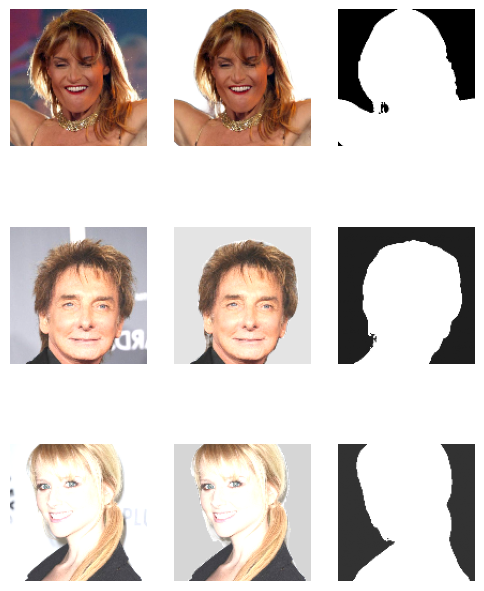

In [8]:
n = 3
images = []
for i in range(n):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    print(sample_idx)
    image, masked, mask = train_set[sample_idx]
    images.extend([image, masked, mask])

visualize(images, 3)

### Model architecture

In [9]:
from torch import nn
import torch


class DoubleConvBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.convs(x)
        return self.pool(x), x


class UpConvBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()
        # self.upconv = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)  # not supported by PyTorch for quantization :(
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(input_channels, output_channels, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.convs = nn.Sequential(
            nn.Conv2d(2 * output_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x1, x2):
        x = torch.concat([x2, self.upconv(x1)], dim=1)
        return self.convs(x)


class UNet(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            DoubleConvBlock(input_channels, 32),
            DoubleConvBlock(32, 64),
            DoubleConvBlock(64, 128),
            DoubleConvBlock(128, 256),
        )
        self.upconv_blocks = nn.Sequential(
            UpConvBlock(256, 128),
            UpConvBlock(128, 64),
            UpConvBlock(64, 32),
        )
        self.last_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        copied_features_list = []
        for conv_block in self.conv_blocks:
            x = conv_block(x)
            copied_features_list.insert(0, x[1])
            x = x[0]
        x, *copied_features_list = copied_features_list
        for upconv_block, copied_features in zip(self.upconv_blocks, copied_features_list):
            x = upconv_block(x, copied_features)
        return self.last_conv(x)

In [10]:
params = sum(p.numel() for p in UNet().parameters())
print(params)

1796577


tensor([0., 0., 0., 0.]) tensor([0.7377, 0.9025, 0.6788, 0.8728])


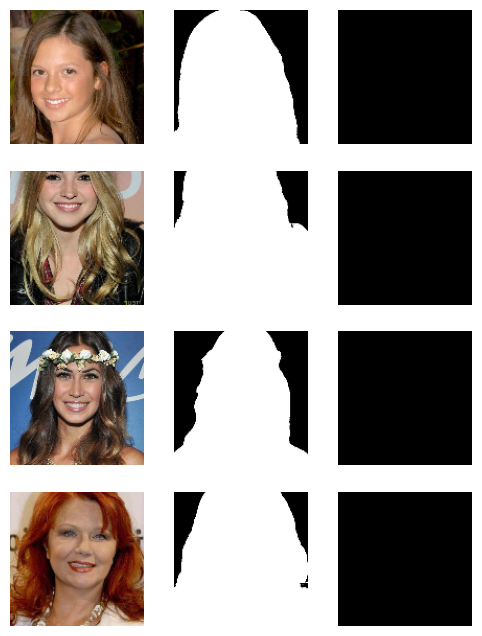

tensor([0., 0., 0., 0.])


In [12]:
x, m, t = train_set[99]
with torch.no_grad():
    y = UNet()(torch.tensor(x).float().unsqueeze(0))


def calculate_metrics(y: torch.Tensor, t: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    mask = (y.sigmoid() > 0.5).bool()
    t = t.bool()
    interception = torch.sum(torch.bitwise_and(mask, t), dim=[1, 2, 3])
    union = torch.sum(torch.bitwise_or(mask, t), dim=[1, 2, 3])
    iou = interception / union
    return iou

from torch.utils.data import DataLoader

# quick check that model and helper functions run ok
calculate_metrics(y, torch.tensor(t).unsqueeze(0))
loader = DataLoader(train_set, batch_size=4, shuffle=False)
for x, _, t in loader:
    with torch.no_grad():
        y = UNet()(x)
        mask = (y.sigmoid() > 0.5).float()
        print(mask.mean(dim=[1, 2, 3]), t.mean(dim=[1, 2, 3]))
        mask = mask.bool()
    images = [item for i in range(4) for item in (x[i].numpy(), t[i].numpy(), mask[i].float().numpy())]
    visualize(images, 3)
    iou = calculate_metrics(y, t)
    print(iou)
    break

### Training

In [13]:
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=3, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
model = UNet().to(device)
optim = Adam(model.parameters(), lr=learning_rate)

import datetime
now_dt_str = datetime.datetime.now().isoformat(timespec='seconds')
exp_dir = f'runs/{now_dt_str}'
import pathlib
(pathlib.Path(os.path.abspath('')) / exp_dir).mkdir(exist_ok=True, parents=True)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(exp_dir)
epochs = 10


for e in range(1, epochs + 1):
    print(f'Epoch {e}')
    
    model.train()
    epoch_train_loss = 0.0
    epoch_train_iou = torch.Tensor().to(device)
    for x, _, t in train_loader:
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y, t)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_train_loss += loss.detach().item()
        with torch.no_grad():
            iou = calculate_metrics(y, t)
            epoch_train_iou = torch.concat([epoch_train_iou, iou])

    epoch_train_loss /= len(train_loader)
    epoch_train_iou = epoch_train_iou.mean().detach().item()
        
    print('Epoch Train Loss', epoch_train_loss)
    print('Epoch Train IOU', epoch_train_iou)
    writer.add_scalar('Loss/train', epoch_train_loss, e)
    writer.add_scalar('IoU/train', epoch_train_iou, e)
    writer.flush()

    epoch_valid_loss = 0.0
    epoch_valid_iou = torch.Tensor().to(device)
    for x, _, t in valid_loader:
        model.eval()
        x = x.to(device)
        t = t.to(device)
        with torch.no_grad():
            y = model(x)
            loss = criterion(y, t)
            epoch_valid_loss += loss.detach().item()
            iou = calculate_metrics(y, t)
            epoch_valid_iou = torch.concat([epoch_valid_iou, iou])
            
    epoch_valid_loss /= len(valid_loader)
    epoch_valid_iou = epoch_valid_iou.mean().detach().item()
    
    print('Epoch Valid Loss', epoch_valid_loss)
    print('Epoch Valid IOU', epoch_valid_iou)
    writer.add_scalar('Loss/valid', epoch_valid_loss, e)
    writer.add_scalar('IoU/valid', epoch_valid_iou, e)
    writer.flush()
writer.close()

torch.save(model.state_dict(), f'{exp_dir}/model.pt')

test_loss = 0.0 
test_iou = torch.Tensor().to(device)
for x, _, t in test_loader:
    model.eval()
    x = x.to(device)
    t = t.to(device)
    with torch.no_grad():
        y = model(x)
        loss = criterion(y, t)
        test_loss += loss.detach().item()
        iou = calculate_metrics(y, t)
        test_iou = torch.concat([test_iou, iou])

test_loss /= len(test_loader)
test_iou = test_iou.mean().detach().item()
    
print('Test Loss', test_loss)
print('Test IOU', test_iou)

Epoch 1


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.5472738802433014
Epoch Train IOU 0.6999624371528625
Epoch Valid Loss 0.36451706503118786
Epoch Valid IOU 0.7708901166915894
Epoch 2


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.35264704070593184
Epoch Train IOU 0.7906035780906677
Epoch Valid Loss 0.29497202379362925
Epoch Valid IOU 0.8217577338218689
Epoch 3


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.28036502536974456
Epoch Train IOU 0.830646276473999
Epoch Valid Loss 0.25497272291353773
Epoch Valid IOU 0.8454880714416504
Epoch 4


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.2218748822023994
Epoch Train IOU 0.8659106492996216
Epoch Valid Loss 0.15244290764842713
Epoch Valid IOU 0.9025005102157593
Epoch 5


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.18816257966192146
Epoch Train IOU 0.8868870139122009
Epoch Valid Loss 0.13256198753203666
Epoch Valid IOU 0.9161208868026733
Epoch 6


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.16723618099564
Epoch Train IOU 0.8990179896354675
Epoch Valid Loss 0.1239991629762309
Epoch Valid IOU 0.9258825182914734
Epoch 7


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.14989640869592366
Epoch Train IOU 0.9087247848510742
Epoch Valid Loss 0.09148779883980751
Epoch Valid IOU 0.9439756870269775
Epoch 8


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.13755629697912616
Epoch Train IOU 0.9161100387573242
Epoch Valid Loss 0.0849002158003194
Epoch Valid IOU 0.9480218291282654
Epoch 9


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.12935254385596828
Epoch Train IOU 0.9207534193992615
Epoch Valid Loss 0.07528132359896388
Epoch Valid IOU 0.9559999108314514
Epoch 10


libpng warning: iCCP: known incorrect sRGB profile


Epoch Train Loss 0.12248361706733704
Epoch Train IOU 0.9239088296890259
Epoch Valid Loss 0.07109192812017032
Epoch Valid IOU 0.9558122158050537
Test Loss 0.06871127613164761
Test IOU 0.9574189782142639


In [19]:
model.eval()
with torch.no_grad():
    image, masked, mask = train_set[0]
    predicted_mask = model(torch.tensor(image).to(device).unsqueeze(0))
    p = predicted_mask.detach().cpu()
    print(p.shape)
p.softmax(dim=0).argmax(dim=0, keepdim=True).median()

torch.Size([1, 1, 128, 128])


tensor(0)

### Post-training Quantization

In [20]:
import torch
import torch.nn as nn
import torch.ao.quantization as quantization

class DoubleConvBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.convs(x)
        return self.pool(x), x

class UpConvBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()
        # self.upconv = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(input_channels, output_channels, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.convs = nn.Sequential(
            nn.Conv2d(2 * output_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x1, x2):
        x = torch.cat([x2, self.upconv(x1)], dim=1)
        return self.convs(x)

class UNet_Q(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        
        self.quant = quantization.QuantStub()
        self.dequant = quantization.DeQuantStub()

        self.conv_blocks = nn.Sequential(
            DoubleConvBlock(input_channels, 32),
            DoubleConvBlock(32, 64),
            DoubleConvBlock(64, 128),
            DoubleConvBlock(128, 256),
            # DoubleConvBlock(256, 512),
            # DoubleConvBlock(512, 1024),
        )
        self.upconv_blocks = nn.ModuleList([
            UpConvBlock(256, 128),
            UpConvBlock(128, 64),          
            UpConvBlock(64, 32),
        ])
        self.last_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        x = self.quant(x)

        copied_features_list = []
        for conv_block in self.conv_blocks:
            x = conv_block(x)
            copied_features_list.insert(0, x[1])
            x = x[0]

        x, *copied_features_list = copied_features_list

        for upconv_block, copied_features in zip(self.upconv_blocks, copied_features_list):
            x = upconv_block(x, copied_features)

        x = self.last_conv(x)
        return self.dequant(x)

In [23]:
# setting things up
torch.use_deterministic_algorithms(False)
model_q = UNet_Q()
model_q = model_q.to(device)
model_q.load_state_dict(model.state_dict())
model_q.eval()
model_q.qconfig = quantization.get_default_qconfig('x86')

modules_to_fuse = []
# for i in range(5):
for i in range(4):
    modules_to_fuse.append([f'conv_blocks.{i}.convs.0', f'conv_blocks.{i}.convs.1'])
    modules_to_fuse.append([f'conv_blocks.{i}.convs.2', f'conv_blocks.{i}.convs.3'])
# for i in range(4):
for i in range(3):
    modules_to_fuse.append([f'upconv_blocks.{i}.upconv.1', f'upconv_blocks.{i}.upconv.2'])
    modules_to_fuse.append([f'upconv_blocks.{i}.convs.0', f'upconv_blocks.{i}.convs.1'])
    modules_to_fuse.append([f'upconv_blocks.{i}.convs.2', f'upconv_blocks.{i}.convs.3'])
model_fused = quantization.fuse_modules(model_q, modules_to_fuse)
model_prepared = quantization.prepare(model_fused)

# calibrate for 100 batches
for i, (x, _, _) in enumerate(train_loader):
    x = x.to(device)
    model_prepared(x)
    if i >= 100:
        break

model_prepared.to('cpu')
model_q = quantization.convert(model_prepared)

/home/lermo/no-git/background_remover/venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
libpng warning: iCCP: known incorrect sRGB profile


### Benchmarking

In [24]:
import os
import torch

def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print(f"{os.path.getsize('tmp.pt') / 1e6:.2f} MB")
    os.remove('tmp.pt')

In [25]:
print_model_size(model)
print_model_size(model_q)

7.20 MB
1.86 MB


In [26]:
import time
import numpy as np


def benchmark(model, input_shape=(1, 3, 128, 128), nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to('cpu')

    print('Warm up ...')
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    print('Start timing ...')
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            output = model(input_data)
            end_time = time.time()
            timings.append(end_time - start_time)
            if i % 100 == 0:
                print(f"Iteration {i}/{nruns}, avg batch time {np.mean(timings) * 1000:.2f} ms")

    print('Input shape:', input_data.size())
    print('Output shape:', output.shape)
    print(f"Average batch time: {np.mean(timings) * 1000:.2f} ms")

In [28]:
benchmark(model.to('cpu').eval(), input_shape=(1, 3, 128, 128))
benchmark(model_q.to('cpu').eval(), input_shape=(1, 3, 128, 128))

Warm up ...
Start timing ...
Iteration 100/1000, avg batch time 8.91 ms
Iteration 200/1000, avg batch time 8.97 ms
Iteration 300/1000, avg batch time 9.02 ms
Iteration 400/1000, avg batch time 9.04 ms
Iteration 500/1000, avg batch time 9.05 ms
Iteration 600/1000, avg batch time 9.06 ms
Iteration 700/1000, avg batch time 9.06 ms
Iteration 800/1000, avg batch time 9.06 ms
Iteration 900/1000, avg batch time 9.07 ms
Iteration 1000/1000, avg batch time 9.08 ms
Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])
Average batch time: 9.08 ms
Warm up ...
Start timing ...


/tmp/ipykernel_76378/4081860751.py:37: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  x = torch.cat([x2, self.upconv(x1)], dim=1)


Iteration 100/1000, avg batch time 2.76 ms
Iteration 200/1000, avg batch time 2.76 ms
Iteration 300/1000, avg batch time 2.75 ms
Iteration 400/1000, avg batch time 2.76 ms
Iteration 500/1000, avg batch time 2.76 ms
Iteration 600/1000, avg batch time 2.76 ms
Iteration 700/1000, avg batch time 2.76 ms
Iteration 800/1000, avg batch time 2.76 ms
Iteration 900/1000, avg batch time 2.76 ms
Iteration 1000/1000, avg batch time 2.76 ms
Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])
Average batch time: 2.76 ms


In [29]:
traced_q = torch.jit.trace(model_q, torch.rand(1, 3, 128, 128))

/tmp/ipykernel_76378/4081860751.py:37: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  x = torch.cat([x2, self.upconv(x1)], dim=1)
/home/lermo/no-git/background_remover/venv/lib/python3.12/site-packages/torch/jit/_trace.py:475: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  outs = wrap_retval(mod(*_clone_inputs(inputs)))


In [30]:
traced_q.save('ready_models/unet_q_traced.pt')

### Misc

In [31]:
import gc

def cleanup():
    model.cpu()
    del model
    gc.collect()
    torch.cuda.empty_cache()